In [1]:
import json
import urllib.request as ur
from tqdm.notebook import tqdm
import datetime as dt

import numpy as np
import pandas as pd
import lmfit
import scipy.stats as sts
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.feature_selection import chi2

from matplotlib import pyplot as plt
from matplotlib import cm
import matplotlib.ticker as mtick
from matplotlib import ticker
from matplotlib import rc
rc('text',usetex=False)

from IPython.display import display, Markdown, Latex

formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1))

%matplotlib inline
#%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

In [2]:
def simple_gompertz_function(x, a, b, k, e):
    exp = - np.exp(k * (b - x))
    return a * np.exp(exp) + e

def double_gompertz_function(x, a1, b1, k1, a2, b2, k2, e):
    exp1 = - np.exp(k1 * (b1 - x))
    g1 = a1 * np.exp(exp1)
    exp2 = - np.exp(k2 * (b2 - x))
    g2 = (a2 - a1) * np.exp(exp2)
    return g1 + g2 + e

def simple_logistic_function(x, a, b, k, e):
    d = k * (b - np.array(x))
    return (a / (1 + np.exp(d))) + e

def double_logistic_function(x, a1, b1, k1, a2, b2, k2, e):
    d1 = k1 * (b1 - np.array(x))
    l1 = a1 / (1 + np.exp(d1))
    d2 = k2 * (b2 - np.array(x))
    l2 = (a2 - a1) / (1 + np.exp(d2))
    return l1 + l2 + e

In [3]:
today = dt.datetime.now().strftime("%Y-%m-%d")
df = pd.read_pickle(f"data-confirmed-{today}.pkl")

In [4]:
def get_models_stats(df):
   
    aics = {}     # Akaike Information Criterion    # compare between models
    redchis = {}  # Reduced chi-square              # the more near 1 the better
    bics = {}     # Bayesian Information Criterion  # the higher the better

    for f in df:
        if f == "measured":
            continue
        aics.update({f: []})
        redchis.update({f: []})
        bics.update({f: []})
        for country in df[f].index:
            if not df[f][country]:
                aics[f].append(0)
                redchis[f].append(0)
                bics[f].append(0)
                continue
            aics[f].append(df[f][country].aic)
            redchis[f].append(df[f][country].redchi)
            bics[f].append(df[f][country].bic)

    return {"aic": aics, "redchi": redchis, "bic": bics}

In [5]:
_stats = get_models_stats(df)

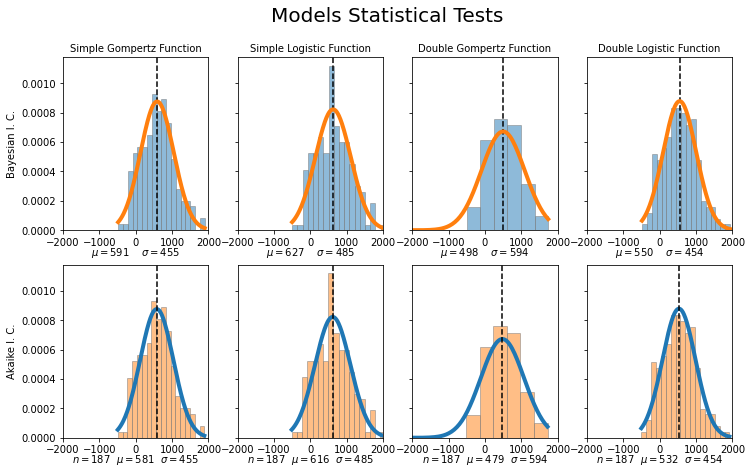

In [55]:
x = np.arange(0, len(_stats["bic"]["Simple Gompertz Function"]))

fig, axs = plt.subplots(2, 4, figsize=(12, 7), sharey=True)

for i, f in enumerate(_stats["bic"]):
    _m, _s = sts.norm.fit(_stats["bic"][f])
    _x = np.linspace(min(_stats["bic"][f]), max(_stats["bic"][f]), len(_stats["bic"][f]))
    fit = sts.norm.pdf(_x, _m, _s)
    axs.flat[i].set_xlabel(
        f"$\mu=${np.mean(_stats['bic'][f]):.0f}    $\sigma=${np.std(_stats['bic'][f]):.0f}",
        labelpad=-2
    )
    axs.flat[i].axvline(np.mean(_stats["bic"][f]), ls="--", c="k")
    axs.flat[i].hist(
        sorted(_stats["bic"][f]),
        density=True, alpha=.5,
        ec="grey",
        bins=len(_stats["bic"][f])//10,
    )
    axs.flat[i].plot(
        _x, fit,
        lw=4,
    )
    axs.flat[i].set_title(f, fontsize=10)
    #axs.flat[i].set_ylim(0, .001)    
    axs.flat[i].set_xlim(-2e3, 2e3)
    #if i:
    #    axs.flat[i].set_yticklabels([])
    if not i:
        axs.flat[i].set_ylabel("Bayesian I. C.")

for i, f in enumerate(_stats["aic"]):
    _m, _s = sts.norm.fit(_stats["aic"][f])
    _x = np.linspace(min(_stats["aic"][f]), max(_stats["aic"][f]), len(_stats["aic"][f]))
    fit = sts.norm.pdf(_x, _m, _s)
    
    axs.flat[i+4].plot(
        _x, fit,
        lw=4,
    )
    axs.flat[i+4].set_xlabel(
        f"$n={len(_stats['aic'][f])}$  $\mu={np.mean(_stats['aic'][f]):.0f}$  $\sigma={np.std(_stats['aic'][f]):.0f}$",
        labelpad=-2
    )
    axs.flat[i+4].axvline(np.mean(_stats["aic"][f]), ls="--", c="k")
    axs.flat[i+4].hist(
        sorted(_stats["aic"][f]),
        density=True, alpha=.5, ec="grey",
        bins=len(_stats["aic"][f])//10,
    )
    #axs.flat[i+4].set_ylim(0, .001)    
    axs.flat[i+4].set_xlim(-2e3, 2e3)
    #if i:
    #    axs.flat[i+4].set_yticklabels([])
    if not i:
        axs.flat[i+4].set_ylabel("Akaike I. C.")
    
fig.suptitle("Models Statistical Tests", fontsize=20)
plt.savefig("aicbic.png", bbox_inches='tight')
plt.show()

In [7]:
def get_models_residual(df):
   
    res = {}

    for f in df:
        if f == "measured":
            continue
        res.update({f: []})
        for country in df[f].index:
            if not df[f][country]:
                continue
            res[f] = np.concatenate((
                res[f],
                df[f][country].residual
            ))

    return res

In [8]:
residual = get_models_residual(df)

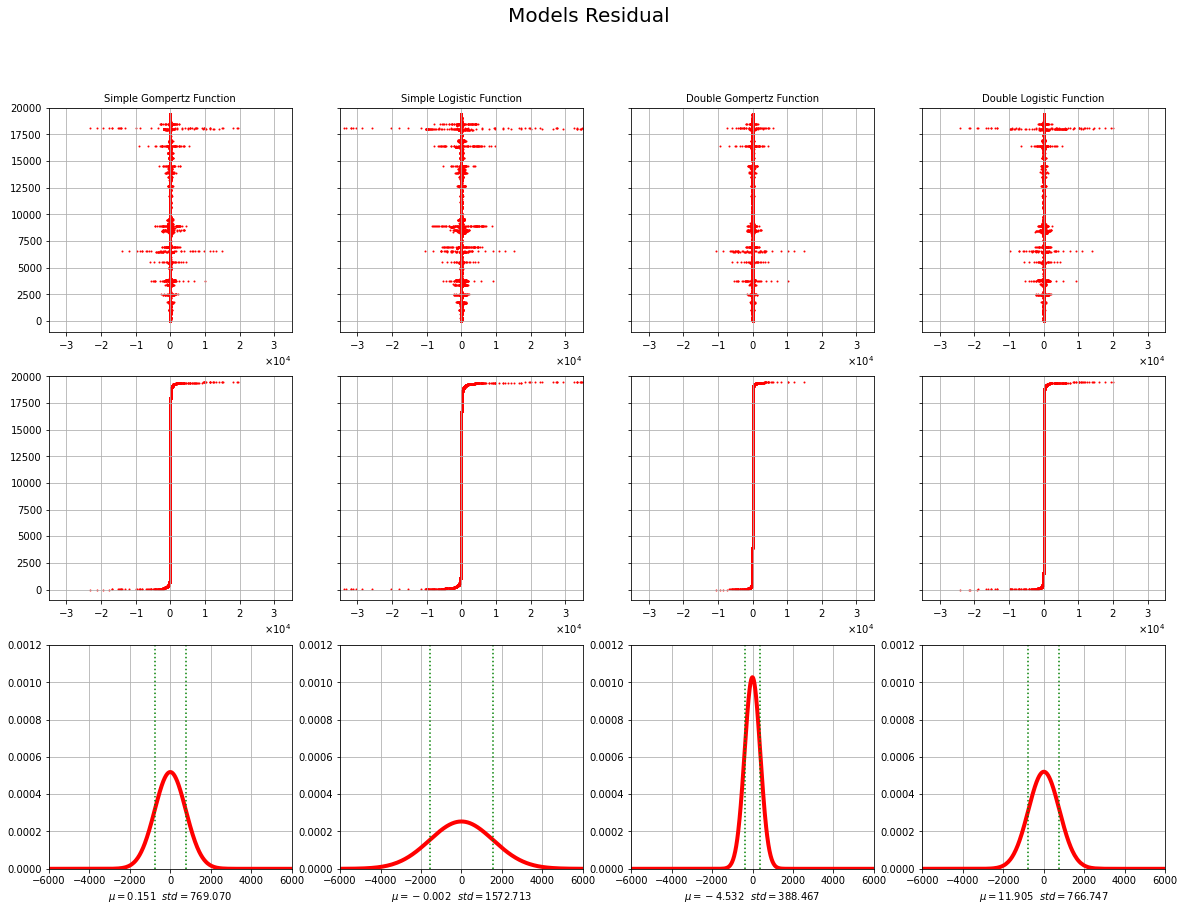

In [9]:
rc('text',usetex=False)
size = 4

fig, axs = plt.subplots(3, 4, figsize=(5*size, 3.5*size))

for i, f in enumerate(residual):
    axs.flat[i].scatter(
        residual[f], np.arange(0, len(residual[f])), 
        c="r", s=1
    )
    axs.flat[i].set_title(f, fontsize=10)
    axs.flat[i].grid(True)
    axs.flat[i].set_xlim(-3.5e4, 3.5e4)
    axs.flat[i].set_ylim(-1e3, 2e4)
    axs.flat[i].xaxis.set_major_formatter(formatter)
    if i:
        axs.flat[i].yaxis.set_ticklabels([])

for i, f in enumerate(residual):
    axs.flat[i+4].scatter(
        sorted(residual[f]), np.arange(0, len(residual[f])), 
        c="r", s=1
    )
    axs.flat[i+4].grid(True)
    axs.flat[i+4].set_xlim(-3.5e4, 3.5e4)
    axs.flat[i+4].set_ylim(-1e3, 2e4)
    axs.flat[i+4].xaxis.set_major_formatter(formatter)
    if i:
        axs.flat[i+4].yaxis.set_ticklabels([])
    
for i, f in enumerate(residual):
    mean = np.mean(residual[f])
    std = np.std(residual[f])
    fit = sts.norm.pdf(
        sorted(residual[f]),
        mean,
        std
    )
    axs.flat[i+8].plot(
        sorted(residual[f]), fit,
        c="r", lw=4
    )

    #x_d = np.linspace(-6e3, 6e3, len(residual[f]))
    #density = sum(sts.norm(xi).pdf(x_d) for xi in sorted(residual[f]))

    #axs.flat[i+8].fill_between(
    #    sorted(residual[f]), density,
    #    #label=_f1name,
    #)
    
    axs.flat[i+8].axvline(mean + std, ls=":", c="g")
    axs.flat[i+8].axvline(mean - std, ls=":", c="g")
    axs.flat[i+8].set_xlabel(f"$\mu = {mean:.3f}$  $std = {std:.3f}$")
    axs.flat[i+8].grid(True)
    axs.flat[i+8].set_ylim(0, 1.2e-3)
    axs.flat[i+8].set_xlim(-6e3, 6e3)
    
    
fig.suptitle("Models Residual", fontsize=20)
plt.savefig("residualstats3.png", bbox_inches='tight')
plt.show()

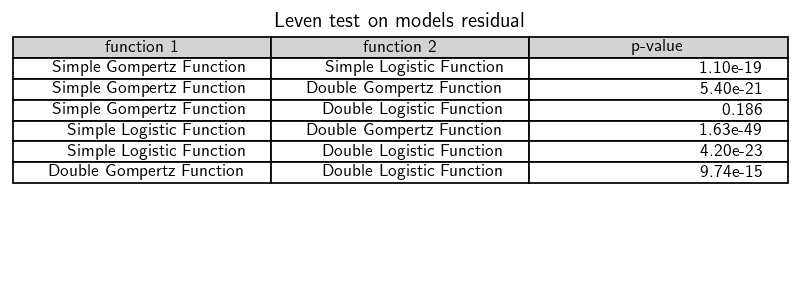

In [10]:
rc('text',usetex=True)
from itertools import combinations as combs

table = []

for i, f in enumerate(combs(residual, 2)):
    if f == "measured":
        continue
    l = sts.levene(
        residual[f[0]],
        residual[f[1]]
    )
    table.append([f[0], f[1], f"{l.pvalue:.3f}" if l.pvalue > .1 else f"{l.pvalue:.2e}"])

fig, ax = plt.subplots(figsize=(8, 1), dpi=125)
plt.axis('tight')
plt.axis("off")
ax.table(
    cellText=table,
    colLabels=["function 1", "function 2", "p-value"],
    loc="top", colColours=["lightgrey", "lightgrey", "lightgrey"]
)
ax.set_title("Leven test on models residual", pad=90)
plt.show()

In [11]:
country_errors = []
for f in df:
    if f == "measured":
        continue
    for country in df[f].index:
        if not df[f][country]:
            country_errors.append(country)

In [12]:
def get_models_predictions(df):
   
    y_true = []
    y_pred = {}

    for f in df:
        if f == "measured":
            continue
        y_pred.update({f: []})
        for country in df[f].index:
            if country in country_errors:
                continue
            y_pred[f] = np.concatenate((
                y_pred[f],
                df[f][country].best_fit
            ))
            
            
    for country in df["measured"].index:
        if country in country_errors:
            continue
        _y = df["measured"][country]
        y_true = np.concatenate((y_true, _y))

    return np.array(y_true), y_pred

In [13]:
y_true, y_pred = get_models_predictions(df)

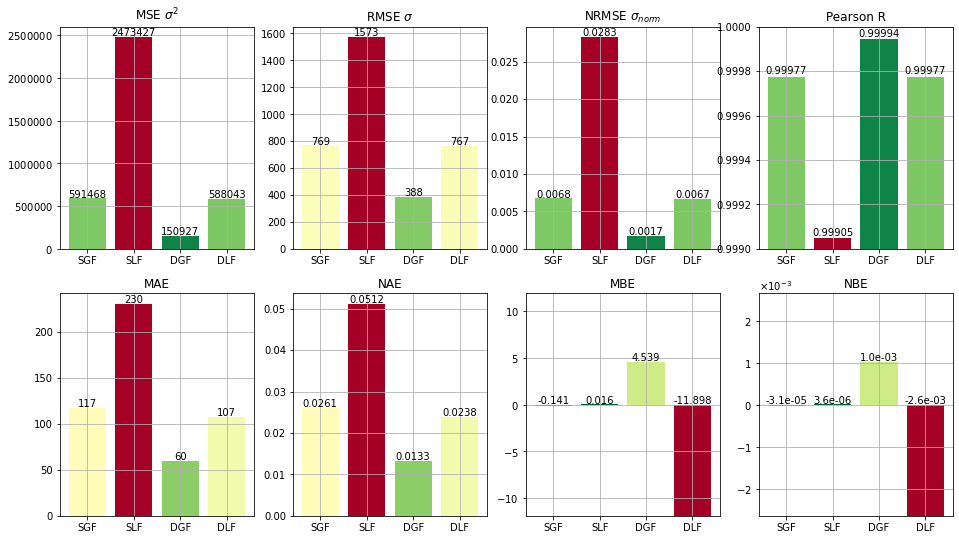

In [35]:
rc('text',usetex=False)
IDXs = {}

fig, axs = plt.subplots(2, 4, figsize=(16, 9))
colors = cm.RdYlGn_r(np.arange(1, 10))

IDXs.update({"mse": {}})
mse_x = np.arange(4)
mse_y = []
mse_labels = [""]
for f in y_pred:
    mse = mean_squared_error(y_true, y_pred[f])
    mse_y.append(mse)
    IDXs["mse"].update({f: mse})
    _fn = "".join(w[0] for w  in f.split(" "))
    mse_labels.append(_fn if len(_fn) == 3 else f"S{_fn}")
colors = cm.RdYlGn_r(np.array(mse_y) / max(mse_y))
rects = axs.flat[0].bar(mse_x, mse_y,color=colors)
for i, _y in enumerate(mse_y):
    axs.flat[0].annotate(s=f"{_y:.0f}", xy=(i, _y), ha='center', xytext=(0, 1), textcoords="offset points")
axs.flat[0].yaxis.set_major_formatter(formatter)
axs.flat[0].set_xticklabels(mse_labels)
axs.flat[0].grid(True)
axs.flat[0].set_title("MSE $\sigma^2$")

IDXs.update({"rmse": {}})
rmse_x = np.arange(4)
rmse_y = []
rmse_labels = [""]
for f in y_pred:
    rmse = np.sqrt(mean_squared_error(y_true, y_pred[f]))
    rmse_y.append(rmse)
    IDXs["rmse"].update({f: rmse})
    _fn = "".join(w[0] for w  in f.split(" "))
    rmse_labels.append(_fn if len(_fn) == 3 else f"S{_fn}")
colors = cm.RdYlGn_r(np.array(rmse_y) / max(rmse_y))
rects = axs.flat[1].bar(rmse_x, rmse_y,color=colors)
for i, _y in enumerate(rmse_y):
    axs.flat[1].annotate(s=f"{_y:.0f}", xy=(i, _y), ha='center', xytext=(0, 1), textcoords="offset points")
axs.flat[1].set_xticklabels(rmse_labels)
axs.flat[1].grid(True)
axs.flat[1].set_title("RMSE $\sigma$")

IDXs.update({"nrmse": {}})
nrmse_x = np.arange(4)
nrmse_y = []
nrmse_labels = [""]
for f in y_pred:
    # normalizer = np.sum(y_pred[f]) / len(y_pred[f])
    nrmse = mean_squared_error(y_true, y_pred[f]) / np.sum(y_true)
    nrmse_y.append(nrmse)
    IDXs["nrmse"].update({f: nrmse})
    _fn = "".join(w[0] for w  in f.split(" "))
    nrmse_labels.append(_fn if len(_fn) == 3 else f"S{_fn}")
colors = cm.RdYlGn_r(np.array(nrmse_y) / max(nrmse_y))
rects = axs.flat[2].bar(nrmse_x, nrmse_y, color=colors)
for i, _y in enumerate(nrmse_y):
    axs.flat[2].annotate(s=f"{_y:.4f}", xy=(i, _y), ha='center', xytext=(0, 1), textcoords="offset points")
axs.flat[2].set_xticklabels(nrmse_labels)
axs.flat[2].grid(True)
axs.flat[2].set_title("NRMSE $\sigma_{norm}$")

IDXs.update({"r": {}})
pearson_r_x = np.arange(4)
pearson_r_y = []
pr_labels = [""]
for f in y_pred:
    pearson_r = sts.pearsonr(y_true, y_pred[f])
    pearson_r_y.append(pearson_r[0])
    IDXs["r"].update({f: pearson_r[0]})
    _fn = "".join(w[0] for w  in f.split(" "))
    pr_labels.append(_fn if len(_fn) == 3 else f"S{_fn}")
min_y = 0.999
rects = axs.flat[3].bar(pearson_r_x, pearson_r_y,color=colors)
for i, _y in enumerate(pearson_r_y):
    axs.flat[3].annotate(s=f"{_y:.5f}", xy=(i, _y), ha='center', xytext=(0, 3), textcoords="offset points")
axs.flat[3].set_xticklabels(pr_labels)
axs.flat[3].grid(True)
axs.flat[3].set_ylim(min_y, 1)
axs.flat[3].set_title("Pearson R")

IDXs.update({"mae": {}})
mae_x = np.arange(4)
mae_y = []
mae_labels = [""]
for f in y_pred:
    mae = mean_absolute_error(y_true, y_pred[f])
    mae_y.append(mae)
    IDXs["mae"].update({f: mae})
    _fn = "".join(w[0] for w  in f.split(" "))
    mae_labels.append(_fn if len(_fn) == 3 else f"S{_fn}")
colors = cm.RdYlGn_r(np.array(mae_y) / max(mae_y))
rects = axs.flat[4].bar(mae_x, mae_y,color=colors)
for i, _y in enumerate(mae_y):
    axs.flat[4].annotate(s=f"{_y:.0f}", xy=(i, _y), ha='center', xytext=(0, 1), textcoords="offset points")
axs.flat[4].set_xticklabels(mae_labels)
axs.flat[4].grid(True)
axs.flat[4].set_title("MAE")

IDXs.update({"nae": {}})
nae_x = np.arange(4)
nae_y = []
nae_labels = [""]
for f in y_pred:
    nae = np.sum(abs( np.array(y_true) - np.array(y_pred[f]) )) / np.sum(y_true)
    nae_y.append(nae)
    IDXs["nae"].update({f: nae})
    _fn = "".join(w[0] for w  in f.split(" "))
    nae_labels.append(_fn if len(_fn) == 3 else f"S{_fn}")
colors = cm.RdYlGn_r(np.array(nae_y) / max(nae_y))
rects = axs.flat[5].bar(nae_x, nae_y, color=colors)
for i, _y in enumerate(nae_y):
    axs.flat[5].annotate(s=f"{_y:.4f}", xy=(i, _y), ha='center', xytext=(0, 1), textcoords="offset points")
axs.flat[5].set_xticklabels(nae_labels)
axs.flat[5].grid(True)
axs.flat[5].set_title("NAE")

IDXs.update({"mbe": {}})
mbe_x = np.arange(4)
mbe_y = []
mbe_labels = [""]
for f in y_pred:
    mbe = np.sum(y_true - y_pred[f]) / len(y_true)
    mbe_y.append(mbe)
    IDXs["mbe"].update({f: mbe})
    _fn = "".join(w[0] for w  in f.split(" "))
    mbe_labels.append(_fn if len(_fn) == 3 else f"S{_fn}")
colors = cm.RdYlGn_r(np.array(np.abs(mbe_y)) / max(np.abs(mbe_y)))
rects = axs.flat[6].bar(mbe_x, mbe_y, color=colors)
for i, _y in enumerate(mbe_y):
    axs.flat[6].annotate(
        s=f"{_y:.3f}", xy=(i, _y if _y>0 else 0), ha='center', xytext=(0, 1), textcoords="offset points")
axs.flat[6].set_ylim(-max(np.abs(mbe_y)), max(np.abs(mbe_y)))
axs.flat[6].yaxis.set_major_formatter(formatter)
axs.flat[6].set_xticklabels(mbe_labels)
axs.flat[6].grid(True)
axs.flat[6].set_title("MBE")

IDXs.update({"nbe": {}})
nbe_x = np.arange(4)
nbe_y = []
nbe_labels = [""]
for f in y_pred:
    nbe = np.sum((y_true - y_pred[f])) / np.sum(y_true)
    nbe_y.append(nbe)
    IDXs["nbe"].update({f: nbe})
    _fn = "".join(w[0] for w  in f.split(" "))
    nbe_labels.append(_fn if len(_fn) == 3 else f"S{_fn}")
colors = cm.RdYlGn_r(np.array(np.abs(nbe_y)) / max(np.abs(nbe_y)))
rects = axs.flat[7].bar(nbe_x, nbe_y,color=colors)
for i, _y in enumerate(nbe_y):
    axs.flat[7].annotate(
        s=f"{_y:.1e}", xy=(i, _y if _y>0 else 0), ha='center', xytext=(0, 1), textcoords="offset points")
axs.flat[7].set_ylim(-max(np.abs(nbe_y)), max(np.abs(nbe_y)))    
axs.flat[7].yaxis.set_major_formatter(formatter)
axs.flat[7].set_xticklabels(nbe_labels)
axs.flat[7].grid(True)
axs.flat[7].set_title("NBE")

plt.savefig("residualstatsok.png", bbox_inches='tight')
plt.show()

In [15]:
old_np_settings = np.seterr(over="raise")

In [16]:
def distribution(diff):
    try:
        return np.exp(-.5 * diff) / (1 + np.exp(-.5 * diff))
    except Exception as err:
        if diff > 0:
            return 1.
        return 0.

In [17]:
AICdensities = {}

In [18]:
def compare_AIC(null_hypothesis):
    AICdensities.update({
        null_hypothesis: {}
    })
    for evaluating in df.columns:
        if evaluating == "measured" or evaluating == null_hypothesis:
            continue
        # AIC
        AICdensities[null_hypothesis].update({evaluating: np.array([])})
        for i, country in enumerate(tqdm(df["measured"].index)):
            H1 = df[evaluating][country]
            H0 = df[null_hypothesis][country]
            if not H1 or not H0:
                continue
            diff = H1.aic - H0.aic
            _y = distribution(diff)
            AICdensities[null_hypothesis][evaluating] = np.append(
                AICdensities[null_hypothesis][evaluating], _y
            )

In [19]:
for function in df.columns:
    if function == "measured":
        continue
    compare_AIC(function)

In [20]:
def plot_compare_AIC():

    fig, axs = plt.subplots(4, 3, figsize=(10, 12), sharey=True, sharex=True)

    for i0, null_hypothesis in enumerate(AICdensities):
        
        alternative_hypothesis = []
        for f in df.columns:
            if f == "measured" or f == null_hypothesis:
                continue
            alternative_hypothesis.append(f)

        for i1, evaluating in enumerate(alternative_hypothesis):
            _x = np.array(sorted(AICdensities[null_hypothesis][evaluating]))
            ay2 = axs.flat[i0*3+i1].twinx()
            ay2.set_yticks([])
            ay2.set_ylabel(evaluating, rotation=270, labelpad=10)
            axs.flat[i0*3+i1].set_title(null_hypothesis)
            axs.flat[i0*3+i1].hist(
                _x,
                density=True,
                bins=10
            )
            axs.flat[i0*3+i1].grid(True)
            axs.flat[i0*3+i1].text(.35, 8.5, "$\mathbf{H_0}$", ha="center", fontsize=15)
            axs.flat[i0*3+i1].text(.65, 8.5, "$H_1$", ha="center", fontsize=15)
            _x0 = len(_x[_x<.5]) / len(_x)
            _x1 = len(_x[_x>.5]) / len(_x)
            axs.flat[i0*3+i1].text(
                .35, 6.5, f"{_x0:.0%}", ha="center", fontsize=12,
                color="g" if _x0 > .5 else "r"
            )
            axs.flat[i0*3+i1].text(
                .65, 6.5, f"{_x1:.0%}", ha="center", fontsize=12,
                #color="g" if _x1 > .5 else "r",
                color="grey"
            )

    axs.flat[0].set_ylim(0, 10)
    axs.flat[0].set_xticks([0, .5, 1])
    axs.flat[0].set_xticklabels(["100%", "50%", "100%"])
    axs.flat[0].set_yticks([0, 2.5, 5, 7.5, 10])
    axs.flat[0].set_yticklabels([])

    plt.suptitle("$\Delta \mathbf{{AIC}}$ $p$ density", fontsize=15)

    plt.savefig("testaic.png", bbox_inches='tight')
    plt.show()

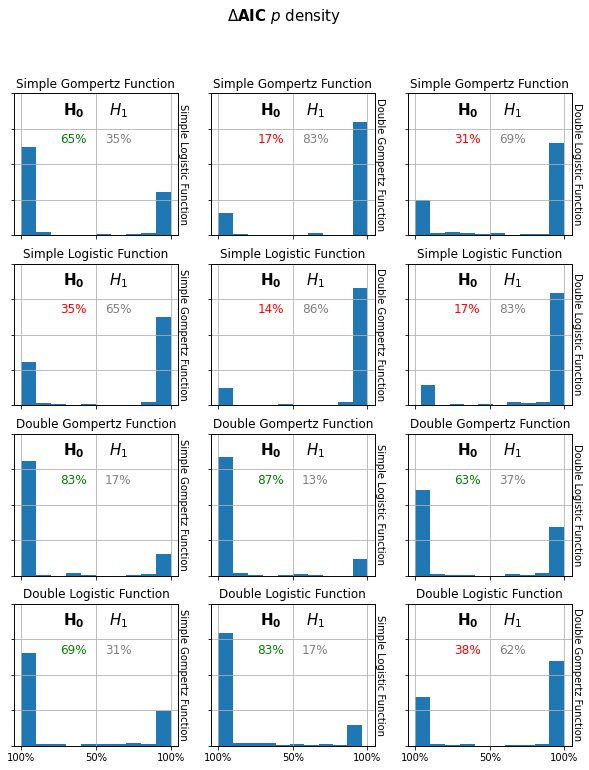

In [21]:
rc('text',usetex=False)
plot_compare_AIC()

In [22]:
def aic_tables():
    for null_hypothesis in AICdensities:
    
        chi_table = []
        rowLabels = []
        colors = ["lightcoral", "lightblue", "lightgreen"]
        rowColors = []

        for i, f in enumerate(AICdensities[null_hypothesis]):
            CHIys1 = AICdensities[null_hypothesis][f][AICdensities[null_hypothesis][f]>.5]
            CHIys2 = AICdensities[null_hypothesis][f][AICdensities[null_hypothesis][f]<=.5]
            chi_table.append([
                f"{CHIys2.size} countries", f"{CHIys1.size} countries",
            ])
            chi_table.append([
                f"{np.mean(1 - CHIys2):.5f}", f"{np.mean(CHIys1):.5f}",
            ])
            chi_table.append([
                f"{np.std(CHIys2):.5f}", f"{np.std(CHIys1):.5f}",
            ])
            _f = "".join([w[0] for w in f.split(" ")])
            if len(_f) == 2:
                _f = "S" + _f
            rowLabels.append(f"{_f} | $p > .5$")
            rowLabels.append(f"{_f} | $\mu$")
            rowLabels.append(f"{_f} | $\sigma$")
            rowColors.append(colors[i])
            rowColors.append(colors[i])
            rowColors.append(colors[i])

        fig, ax = plt.subplots(figsize=(3, 1), dpi=125)
        plt.axis('tight')
        plt.axis("off")
        ax.table(
            cellText=chi_table,
            colLabels=["$H_0$", "$H_1$"],
            rowLabels=rowLabels,
            rowColours=rowColors,
            loc="center", colColours=["lightyellow", "lightgrey"],
        )
        plt.title(f"{null_hypothesis}\n$\mathbf{{AIC}}$ scores", pad=125)
        plt.show()

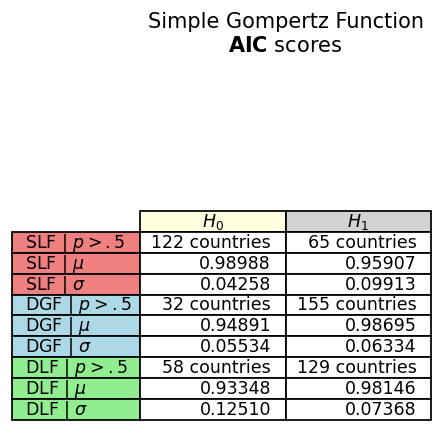

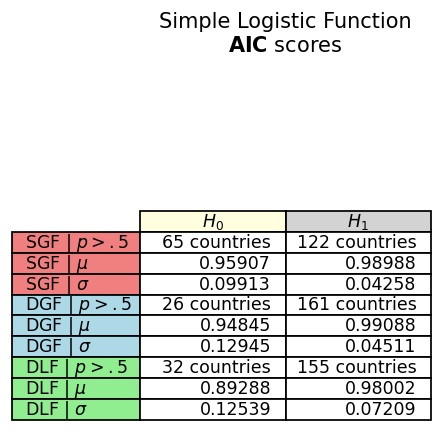

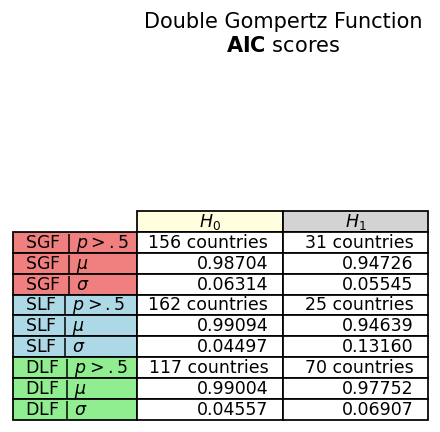

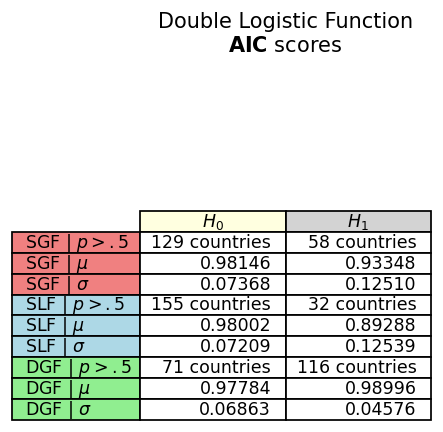

In [23]:
aic_tables()

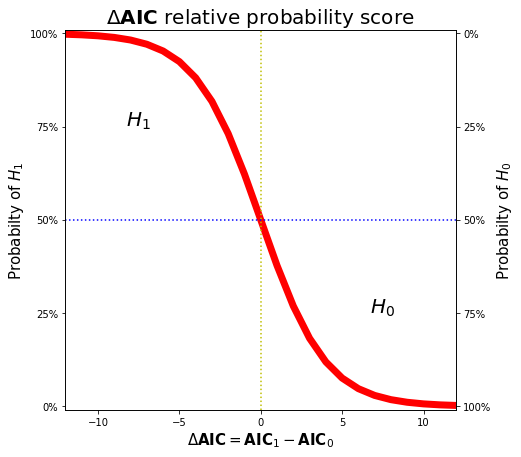

In [32]:
_x = np.arange(-100, 100, 1)
_y = distribution(_x) * 100

fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.plot(_x, _y, lw=7, c="r")
xlim = 12
ax.set_xlim(-xlim, xlim)
ax.axvline(0, ls=":", c="y")
ax.axhline(50, ls=":", c="b")
ax2 = ax.twinx()
ax.set_ylim(-1, 101)
ax2.set_ylim(101, -1)
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel("Probabilty of $H_1$", fontsize=15)
ax2.set_ylabel("Probabilty of $H_0$", fontsize=15)
ax.text(-7.5, 75, "$H_1$", fontsize=20, ha="center")
ax.text(7.5, 25, "$H_0$", fontsize=20, ha="center")
ax.set_xlabel("$\Delta\mathbf{AIC} = \mathbf{AIC}_1 - \mathbf{AIC}_0$", fontsize=15)
ax.set_title("$\Delta\mathbf{AIC}$ relative probability score", fontsize=20)

ax.set_yticks([0, 25, 50, 75, 100])
ax2.set_yticks([0, 25, 50, 75, 100])

plt.show()

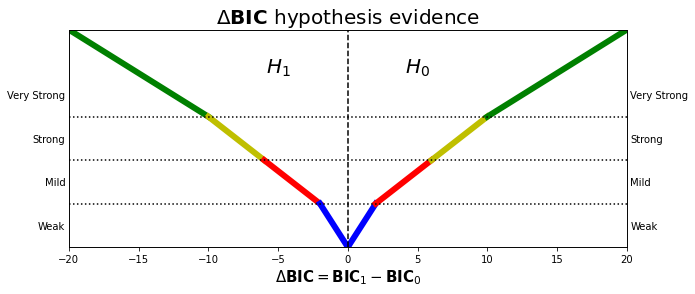

In [33]:
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(
    [-10, -20],
    [3, 5],
    color="g", lw=6
)
ax.plot(
    [-6, -10],
    [2, 3],
    color="y", lw=6
)
ax.plot(
    [-2, -6],
    [1, 2],
    color="r", lw=6
)
ax.plot(
    [0, -2],
    [0, 1],
    color="b", lw=6
)

ax.plot(
    [0, 2],
    [0, 1],
    color="b", lw=6
)
ax.plot(
    [2, 6],
    [1, 2],
    color="r", lw=6
)
ax.plot(
    [6, 10],
    [2, 3],
    color="y", lw=6
)
ax.plot(
    [10, 20],
    [3, 5],
    color="g", lw=6
)

ax.set_yticks([.5, 1.5, 2.5, 3.5])
ax.set_yticklabels(["Weak", "Mild", "Strong", "Very Strong"])
ax2 = plt.twinx()
ax2.set_ylim(0, 5)
ax2.set_yticks([.5, 1.5, 2.5, 3.5])
ax2.set_yticklabels(["Weak", "Mild", "Strong", "Very Strong"], )
ax.tick_params("y", length=0)
ax2.tick_params("y", length=0)

for y in [1, 2, 3]:
    ax.axhline(y, ls=":", c="k")
ax.axvline(0, ls="--", c="k")

ax.set_xlim(-20, 20)
ax.set_ylim(0, 5)

ax.set_xlabel("$\Delta\mathbf{BIC} = \mathbf{BIC}_1 - \mathbf{BIC}_0$", fontsize=15)
ax.text(5, 4, "$H_0$", fontsize=20, ha="center")
ax.text(-5, 4, "$H_1$", fontsize=20, ha="center")
ax.set_title("$\Delta\mathbf{BIC}$ hypothesis evidence", fontsize=20)
plt.show()

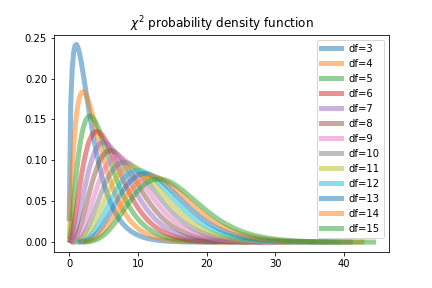

In [32]:
for dof in np.arange(3, 16):
    c2mean, c2var, c2skew, c2kurt = sts.chi2.stats(dof, moments='mvsk')
    c2x = np.linspace(
        sts.chi2.ppf(0.0001, dof), sts.chi2.ppf(0.9999, dof), 100
    )
    plt.plot(
        c2x, sts.chi2.pdf(c2x, dof),
        '-', lw=5, alpha=.5, label=f'df={dof}'
    )
#plt.xlim(0, 1)
plt.legend(loc="best")
plt.title("$\chi^2$ probability density function")
plt.show()

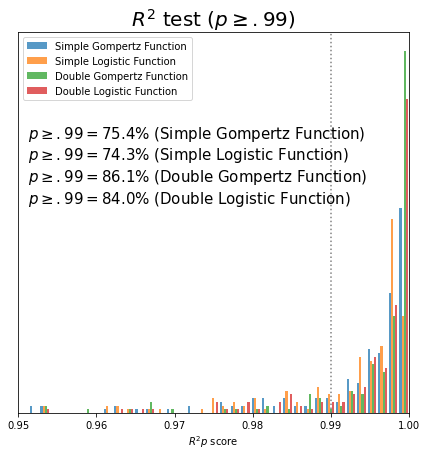

In [24]:
# R2 scores

R2 = {}
functions = df.columns

fig, ax = plt.subplots(1, 1, figsize=(7, 7))
txt = ""
for i, function in enumerate(functions):
    if function == "measured":
        continue
    R2.update({function: []})
    for country in df[function].index:
        if not df[function][country]:
            continue
        obs = df["measured"][country]
        exp = df[function][country].best_fit
        tss = np.sum((obs - np.mean(obs)) ** 2)
        rss = df[function][country].chisqr
        r2 = (1 - rss / tss)
        R2[function].append(r2)
    R2[function] = np.array(R2[function])
    txt += "$p\geq.99={:.1%}$% ({})\n".format(
        len(R2[function][R2[function]>=.99]) / len(R2[function]),
        function,
    )
ax.hist(
    [R2[functions[1]], R2[functions[2]], R2[functions[3]], R2[functions[4]]],
    label=functions[1:],
    bins=len(R2[function])//2, alpha=.75,
    #density=True
)
ax.axvline(.99, c="grey", ls=":")
ax.axhline(0, c="grey", lw=1)
plt.legend(loc="best")
plt.xlim(.95, 1.)
plt.title("$R^2$ test ($p\geq.99$)", fontsize=20)
ax.text(.025, .5, txt, fontsize=15, transform=ax.transAxes)
ax.set_xlabel("$R^2 p$ score")
ax.set_yticks([])

plt.savefig("testr2.png", bbox_inches='tight')
plt.show()

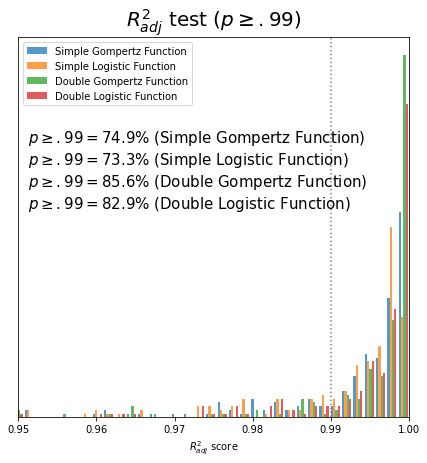

In [25]:
# Adjusted R2 scores

rR2 = {}
functions = df.columns

fig, ax = plt.subplots(1, 1, figsize=(7, 7))
txt = ""
for i, function in enumerate(functions):
    if function == "measured":
        continue
    rR2.update({function: []})
    for country in df[function].index:
        if not df[function][country]:
            continue
        n = df[function][country].best_fit.size
        p = df[function][country].nvarys
        obs = df["measured"][country]
        tss = np.sum((obs - np.mean(obs)) ** 2)
        rss = df[function][country].chisqr
        _r2 = rss / tss
        rr2 = 1 - _r2 * ((n - 1) / (n - p - 1))
        rR2[function].append(rr2)
    rR2[function] = np.array(sorted(rR2[function]))
    txt += "$p\geq.99={:.1%}$% ({})\n".format(
        len(rR2[function][rR2[function]>=.99]) / len(rR2[function]),
        function,
    )
    
    #x_d = np.linspace(0, 1., len(rR2[function]))
    #density = sum(sts.norm(xi).pdf(x_d) for xi in rR2[function])
    
    #ax.plot(
    #    rR2[function], density,
    #    label=function,
    #    alpha=.75
    #)
    
ax.hist(
    [rR2[functions[1]], rR2[functions[2]], rR2[functions[3]], rR2[functions[4]]],
    label=functions[1:],
    bins=len(rR2[function])//2, alpha=.75,
    #density=True
)
ax.axvline(.99, c="grey", ls=":")
plt.legend(loc="best")
plt.xlim(.95, 1.)
plt.title("$R^2_{adj}$ test ($p\geq.99$)", fontsize=20)
ax.text(.025, .5, txt, fontsize=15, transform=ax.transAxes)
ax.set_xlabel("$R^2_{adj}$ score")
ax.set_yticks([])
plt.savefig("testr2adj.png", bbox_inches='tight')
plt.show()

In [26]:
functions = df.columns
BICs = {}
BICc = {}
for f0 in functions:
    if f0 == "measured":
        continue
    BICs.update({f0: {}})
    BICc.update({f0: {}})
    for f1 in functions:
        if f1 == "measured":
            continue
        if f1 == f0:
            continue
        BICs[f0].update({f1: []})
        BICc[f0].update({f1: []})
        for country in df[f1].index:
            if not df[f0][country]:
                continue
            if not df[f1][country]:
                continue
            bic0 = df[f0][country].bic
            bic1 = df[f1][country].bic
            delta = bic1 - bic0
            BICs[f0][f1].append(delta)
            if delta < 0:
                BICc[f0][f1].append(country)

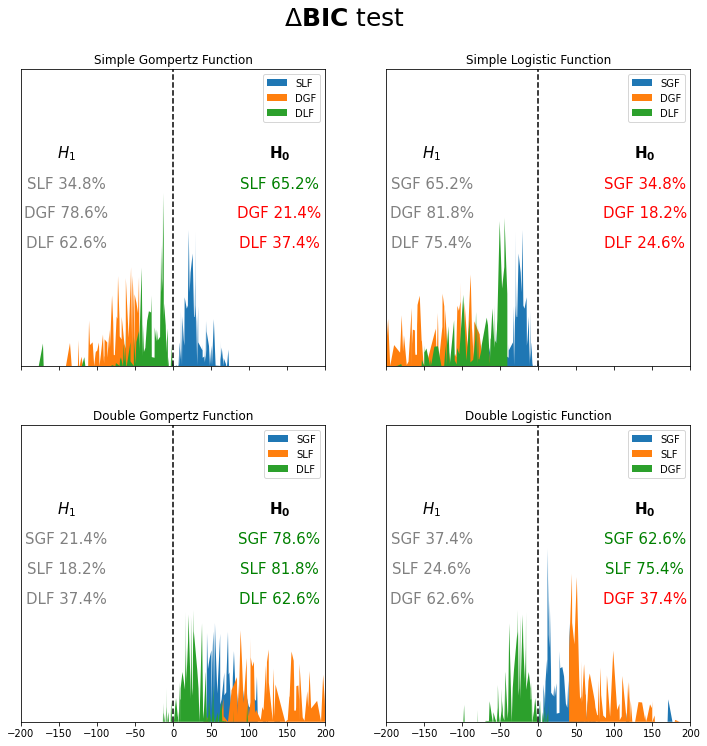

In [27]:
BICcolors = {"SLF":"r", "SGF": "y", "DLF": "b", "DGF": "c"}

fig, ax = plt.subplots(2, 2, figsize=(12, 12), sharex=True, sharey=True)
for i, f0 in enumerate(BICs):
    _n = []
    histcol = []
    #txt0 = ""
    #txt1 = ""
    for j, f1 in enumerate(BICs[f0]):
        _f1 = np.array(sorted(BICs[f0][f1]))
        _n.append(_f1)
        _l20 = len(_f1[_f1<0]) / len(_f1)
        _g20 = len(_f1[_f1>=0]) / len(_f1)
        _f1name = "".join(w[0] for w in f1.split(" "))
        txt0 = f"{_f1name} {_g20:.1%}"
        txt1 = f"{_f1name} {_l20:.1%}"
        ax.flat[i].text(.85, .6-(j/10), txt0,
                        color="g" if _g20 >= _l20 else "r",
                        transform=ax.flat[i].transAxes,
                        ha="center", fontsize=15)
        ax.flat[i].text(.15, .6-(j/10), txt1,
                        color="grey",
                        transform=ax.flat[i].transAxes,
                        ha="center", fontsize=15)
        histcol.append(BICcolors[_f1name])
        _x = np.arange(0, len(_f1))
        
        x_d = np.linspace(-500, 500, len(_f1))
        density = sum(sts.norm(xi).pdf(x_d) for xi in _f1)

        ax.flat[i].fill_between(
            _f1, density,
            label=_f1name,
        )
    ax.flat[i].set_title(f0)
    ax.flat[i].legend(loc="best")
    ax.flat[i].axvline(0, ls="--", c="black")
    ax.flat[i].axhline(0, c="grey", lw=1)
    ax.flat[i].text(.85, .75, f"$\mathbf{{H_0}}$", ha="center", va="top", fontsize=15, transform=ax.flat[i].transAxes)
    ax.flat[i].text(.15, .75, f"$H_1$", ha="center", va="top", fontsize=15, transform=ax.flat[i].transAxes)
plt.yticks([])
plt.ylim(0, 5)
plt.xlim(-200, 200)
plt.suptitle("$\Delta \mathbf{BIC}$ test", fontsize=25, va="bottom", y=0.925)

plt.savefig("testbic.png", bbox_inches='tight')
plt.show()

In [28]:
Ttable = [[], [], [], []]
for j, H0 in enumerate(BICs):
    _H0 = "".join([w[0] for w in H0.split(" ")])
    aic_txt = []
    bic_txt = []
    h1_txt = []
    for i, H1 in enumerate(BICs[H0]):
        _H1 = "".join([w[0] for w in H1.split(" ")])
        _a = AICdensities[H0][H1]
        _b = np.array(BICs[H0][H1])
        aic_txt.append(f"${len(_a[_a<.5])/len(_a)*100:.2f}\%$")
        bic_txt.append(f"${len(_b[_b>0.])/len(_b)*100:.2f}\%$")
        h1_txt.append(_H1)
    Ttable[j] = [
        f"$\mathbf{{{_H0}}}$",
        f"${IDXs['mae'][H0]:.0f}$", 
        f"${IDXs['nae'][H0]:.6f}$", 
        f"${IDXs['mse'][H0]:.0f}$", 
        f"${IDXs['rmse'][H0]:.0f}$", 
        f"${IDXs['nrmse'][H0]:.6f}$", 
        f"${IDXs['r'][H0]:.6f}$", 
        f"${len( R2[H0][ R2[H0]>=.99])/len( R2[H0])*100:.2f}\%$",
        f"${len(rR2[H0][rR2[H0]>=.99])/len(rR2[H0])*100:.2f}\%$",
        "\n".join(aic_txt), "\n".join(bic_txt), "\n".join(h1_txt)
    ]

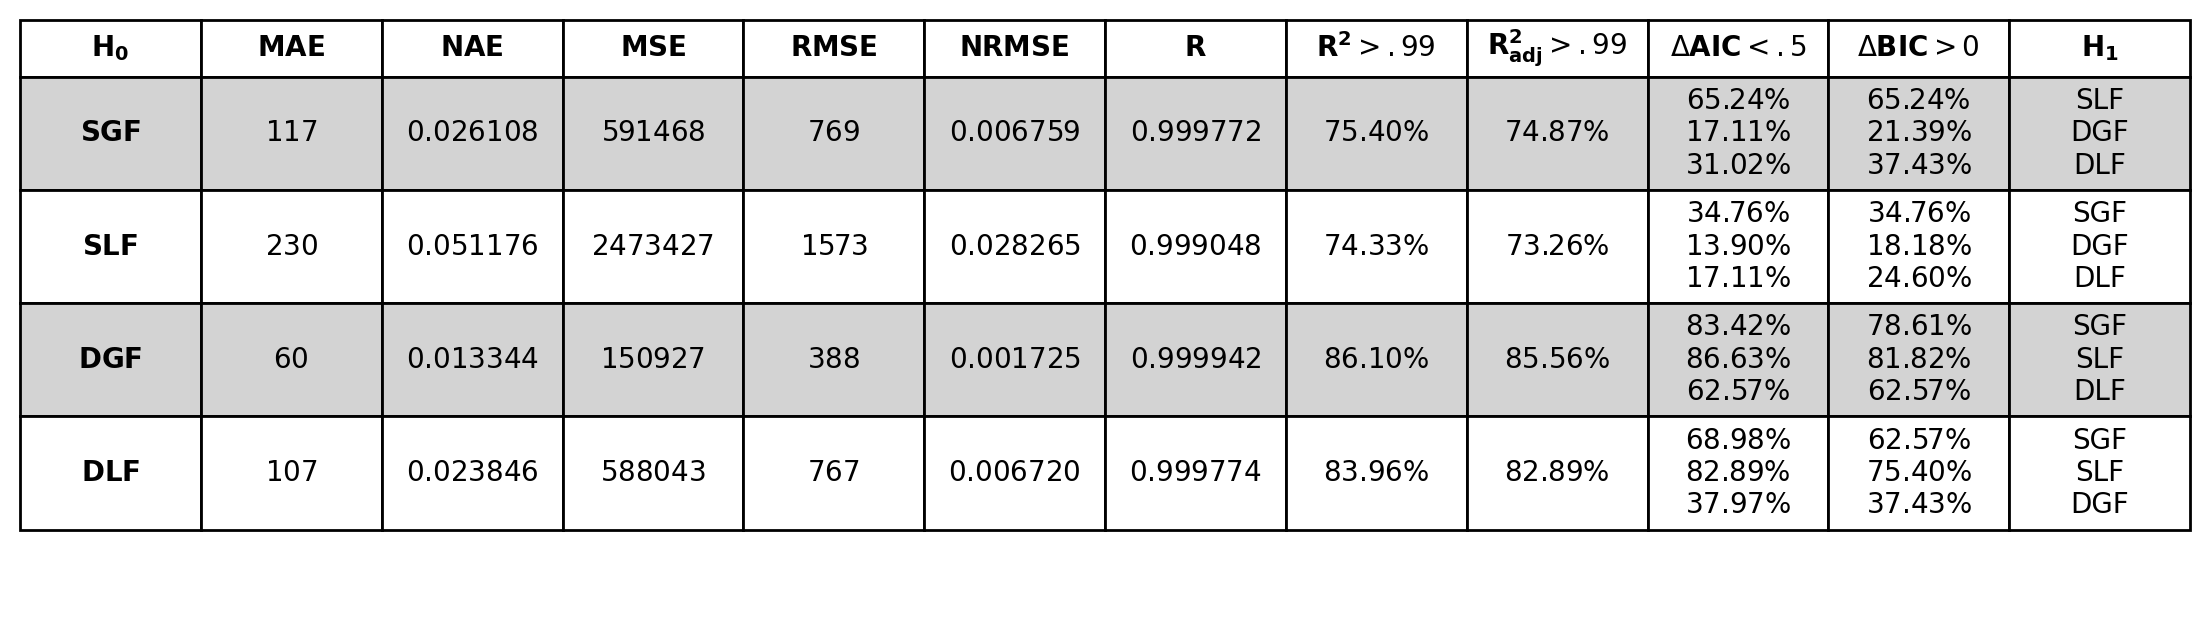

In [29]:
rc('text',usetex=False)
fig, ax = plt.subplots(figsize=(14, .5), dpi=200)
plt.axis('tight')
plt.axis("off")
ytable = ax.table(
    cellText=Ttable,
    cellColours=[
        ["lightgrey" for _ in range(12)],
        ["w" for _ in range(12)],
        ["lightgrey" for _ in range(12)],
        ["w" for _ in range(12)],
    ], 
    cellLoc='center',
    colWidths=None,
    colLabels=["$\mathbf{H_0}$",
               "$\mathbf{MAE}$", "$\mathbf{NAE}$", "$\mathbf{MSE}$", 
               "$\mathbf{RMSE}$", "$\mathbf{NRMSE}$", "$\mathbf{R}$",
               "$\mathbf{R^2}>.99$", "$\mathbf{R^2_{adj}}>.99$", 
               "$\Delta\mathbf{AIC}<.5$", "$\Delta\mathbf{BIC}>0$", 
               "$\mathbf{H_1}$"],
    colColours=None,
    colLoc='center',
    loc='top',
    bbox=None,
    edges='closed',
)
cellDict = ytable.get_celld()
for i in range(12):
    cellDict[(0,i)].set_height(.75)
    for j in range(4):
        cellDict[(j+1,i)].set_height(1.5)

plt.savefig("testtable.png", bbox_inches="tight")
plt.show()

In [36]:
head = r"""
\begin{table}
  \begin{center}
    \caption{Models statistics.}
    \label{tab:table1}
    \resizebox{\textwidth}{!} {
    \begin{tabular}{c|c|c|c|c|c|c|c|c|c|c|c|c|c}
        \toprule
        & & & & & & & & & $p>.99$ & $p>.99$ & $p<.5$ & $\Delta > 0$ & \\
        $\mathbf{H_0}$ &
        $\mathbf{MAE}$ & $\mathbf{NAE}$ & 
        $\mathbf{MBE}$ & $\mathbf{NBE}$ & 
        $\mathbf{MSE}$ & $\mathbf{RMSE}$ &
        $\mathbf{NRMSE}$ & $\mathbf{R}$ &
        $\mathbf{R^2}$ & $\mathbf{R^2_{adj}}$ &
        $\Delta \mathbf{AIC}$ & $\Delta \mathbf{BIC}$ &
        $\mathbf{H_1}$ \\
"""

_body = r"""
        \midrule
         & & & & & & & & & & & {a0:.2f}\% & {b0:.2f}\% & {h10} \\
         \textbf{{{_H0}}} & 
             {mae:.0f} & {nae:.4f} & 
             {mbe:.2f} & {nbe:.1e} & 
             {mse:.0f} & {rmse:.0f} & 
             {nrmse:.6f} & {r:.6f} & 
             {r2:.2f}\% & 
             {r2a:.2f}\% & 
             {a1:.2f}\% & {b1:.2f}\% & {h11} \\
         & & & & & & & & & & & {a2:.2f}\% & {b2:.2f}\% & {h12} \\
"""

tail = r"""
        \bottomrule
    \end{tabular} }
  \end{center}
\end{table}
"""

body = ""
for j, H0 in enumerate(BICs):
    _H0 = "".join([w[0] for w in H0.split(" ")])
    _a = []
    _b = []
    _h1 = []
    for i, H1 in enumerate(BICs[H0]):
        __h1 = "".join([w[0] for w in H1.split(" ")])
        __a = AICdensities[H0][H1]
        __b = np.array(BICs[H0][H1])
        _a.append(len(__a[__a<.5])/len(__a)*100)
        _b.append(len(__b[__b>0.])/len(__b)*100)
        _h1.append(__h1)

    body += _body.format(
        _H0=_H0,
        mae=IDXs['mae'][H0], nae=IDXs['nae'][H0],
        mbe=IDXs['mbe'][H0], nbe=IDXs['nbe'][H0],
        mse=IDXs['mse'][H0], rmse=IDXs['rmse'][H0],
        nrmse=IDXs['nrmse'][H0], r=IDXs['r'][H0],
        r2=len( R2[H0][ R2[H0]>=.99])/len( R2[H0])*100,
        r2a=len(rR2[H0][rR2[H0]>=.99])/len(rR2[H0])*100,
        a0=_a[0], b0=_b[0], h10=_h1[0],
        a1=_a[1], b1=_b[1], h11=_h1[1],
        a2=_a[2], b2=_b[2], h12=_h1[2],
    )

table = head + body + tail
with open("modelstable.tex", "w") as _file:
    _file.write(table)